In [25]:
# In[1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plotting style
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_theme(style="whitegrid")


In [26]:
# Load the dataset and perform initial cleaning
file_path = '..\\..\\data\\csv\\FY_2022-2025.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

print("Shape after load:", df.shape)

# Convert relevant columns to numeric, coercing errors
for col in df.columns:
    if 'ERR for' in col or 'Number of eligible discharges' in col or 'DRG payment ratio' in col:
        df[col] = pd.to_numeric(df[col], errors='coerce')

Shape after load: (9063, 37)


In [27]:
# ---Feature Engineering ---

# Create an overall penalty flag
penalty_cols = [col for col in df.columns if 'Penalty indicator for' in col]
df['Overall_Penalty'] = df[penalty_cols].apply(lambda row: 1 if 'Y' in row.values else 0, axis=1)

# Sort data to create lagged features
df.sort_values(by=['Hospital CCN', 'Year'], inplace=True)

# Create lagged penalty feature (penalty status in the previous year)
df['Overall_Penalty_Last_Year'] = df.groupby('Hospital CCN')['Overall_Penalty'].shift(1)

# Create interaction terms
top_conditions = ['HF', 'COPD', 'AMI']
for cond in top_conditions:
    err_col = f'ERR for {cond}'
    if 'Dual proportion' in df.columns and err_col in df.columns:
        df[f'Dual_x_ERR_{cond}'] = df['Dual proportion'] * df[err_col]

# Define feature and target columns
feature_cols = [
    'Dual proportion', 'Overall_Penalty_Last_Year', 'ERR for AMI', 'ERR for COPD', 'ERR for HF',
    'ERR for pneumonia', 'ERR for CABG', 'ERR for THA/TKA',
    'Dual_x_ERR_HF', 'Dual_x_ERR_COPD', 'Dual_x_ERR_AMI'
]
target_col = 'Payment reduction percentage'

# Fill any NaNs in our feature set with the median
for col in feature_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows where the lagged feature or the target variable is missing
df_model = df.dropna(subset=['Overall_Penalty_Last_Year', target_col]).copy()

print("Shape after feature engineering and cleaning:", df_model.shape)

Shape after feature engineering and cleaning: (9061, 42)


In [28]:
# We will train on data up to 2024 to predict for 2025
train_df = df_model[df_model['Year'] < 2025]
test_df = df_model[df_model['Year'] == 2025]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Create a pipeline with scaling and the XGBoost Regressor model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Define a hyperparameter grid for tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__subsample': [0.8, 1.0]
}

# Perform GridSearchCV
print("\n--- Starting XGBoost Regressor Training and Tuning ---")
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters found for XGBoost: {grid_search.best_params_}")
print(f"Best MSE Score (CV): {-grid_search.best_score_:.4f}")


Training set shape: (6081, 11)
Test set shape: (2980, 11)

--- Starting XGBoost Regressor Training and Tuning ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters found for XGBoost: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best MSE Score (CV): 0.0513


In [29]:
# Make predictions on the 2025 test data
y_pred = best_model.predict(X_test)

# Add predictions to the test dataframe
results_df = test_df.copy()
results_df['Predicted_Reduction'] = y_pred

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Evaluation on FY 2025 Data ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


--- Final Model Evaluation on FY 2025 Data ---
Mean Squared Error (MSE): 0.2510
R-squared (R2): -0.4046



--- Top 20 Hospitals with Highest Predicted Payment Reductions for FY 2025 ---
     Hospital CCN  Predicted_Reduction
1243       190298             1.829559
2654       450880             1.715955
2368       430089             1.643766
452         50766             1.321389
130         30112             1.222544
2651       450874             1.110305
2640       450853             0.889160
1027       150167             0.862961
1242       190278             0.813898
2930       670054             0.813898
2973       670266             0.776514
2619       450774             0.755030
2660       450891             0.755030
2898       520205             0.632586
127         30108             0.613133
1032       150177             0.599834
428         50714             0.584625
1240       190270             0.536687
2053       360355             0.528455
2057       360361             0.501313


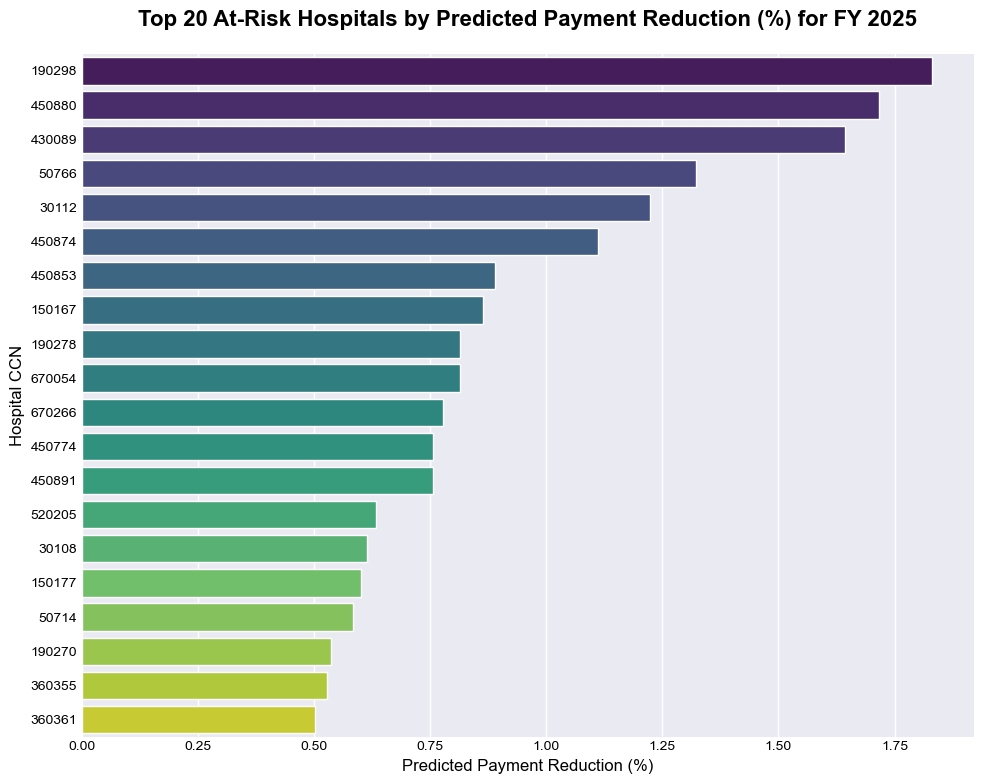

In [30]:
# --- Identify and Display Top At-Risk Hospitals for FY 2025 ---

# Sort hospitals by the highest predicted reduction
top_at_risk_hospitals = results_df.sort_values('Predicted_Reduction', ascending=False).head(20)

print("\n--- Top 20 Hospitals with Highest Predicted Payment Reductions for FY 2025 ---")
print(top_at_risk_hospitals[['Hospital CCN', 'Predicted_Reduction']])

# --- Improved Visualization ---
# Use a style with better contrast
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 8))
sns.barplot(x='Predicted_Reduction', y='Hospital CCN', data=top_at_risk_hospitals,
            palette='viridis', orient='h') # Changed palette for better contrast

plt.title('Top 20 At-Risk Hospitals by Predicted Payment Reduction (%) for FY 2025',
          fontsize=16, weight='bold', pad=20, color='black') # Set title color
plt.xlabel('Predicted Payment Reduction (%)', fontsize=12, color='black') # Set label color
plt.ylabel('Hospital CCN', fontsize=12, color='black') # Set label color

# Ensure tick labels are visible
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

plt.tight_layout()
plt.show()